#### 1. CODIFY THE TEXT USING BERT

Python 3.8

De forma local optimiza el uso del GPU

In [11]:
text = "the scene is in the in the kitchen . the mother is wiping dishes and the water is running on the floor . a child is trying to get a boy is trying to get cookies outta a jar and hes about to tip over on a stool . uh the little girl is reacting to his falling . uh it seems to be summer out . the window is open . the curtains are blowing . it must be a gentle breeze . theres grass outside in the garden . uh mothers finished certain of the the dishes . kitchens very tidy . the mother seems to have nothing in the house to eat except cookies in the cookie jar . uh the children look to be almost about the same size . perhaps theyre twins . theyre dressed for summer warm weather . um you want more the mothers in a short sleeve dress . Ill hafta say its warm ."

import tensorflow as tf
from transformers import BertConfig, TFBertModel, BertTokenizer

custom_config = BertConfig(
    vocab_size=30522,               
    num_attention_heads=12,         
    num_hidden_layers=12,          
    attention_probs_dropout_prob=0.1,  
    hidden_size=768,                
    intermediate_size=3072,        
    hidden_dropout_prob=0.1,        
    hidden_act="relu",              
    max_position_embeddings=512    
)

model = TFBertModel(custom_config)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

inputs = tokenizer(
    text,
    return_tensors="tf",
    padding=True,
    truncation=True,
    max_length=512
)

bert_outputs = model(**inputs)

bert_last_hidden_state = bert_outputs.last_hidden_state 
bert_pooled_output = bert_outputs.pooler_output        

print("Last Hidden State Shape:", bert_last_hidden_state.shape)

# shape: number of samples is 1, number of tokens is 171 and size of the embedding vector is 768

Last Hidden State Shape: (1, 171, 768)


#### 2.1. CNN TEXT MODEL

In [12]:
class TextCNN(tf.keras.Model):
    def __init__(self, dropout_prob=0.5):
        super(TextCNN, self).__init__()
        
        # convolution kernels
        self.conv1 = tf.keras.layers.Conv2D(130, (5, 768), activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(130, (10, 768), activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(130, (15, 768), activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(130, (20, 768), activation='relu')

        # max pooling
        self.pool = tf.keras.layers.GlobalMaxPooling2D()

        # fusion layer
        self.fc = tf.keras.layers.Dense(260, activation='relu')
        self.dropout = tf.keras.layers.Dropout(dropout_prob)

    def call(self, inputs):
        # input the output of the bert model
        x = tf.expand_dims(inputs, -1) 
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        
        # pool the outputs of the convolution layers 
        pooled_1 = self.pool(x1)
        pooled_2 = self.pool(x2)
        pooled_3 = self.pool(x3)
        pooled_4 = self.pool(x4)
        
        # fusion of all the features
        fused_features = tf.concat([pooled_1, pooled_2, pooled_3, pooled_4], axis=-1)

        feature_vector = self.fc(fused_features)
        feature_vector = self.dropout(feature_vector)
        
        return feature_vector

textcnn_model = TextCNN()
feature_vector_cnn = textcnn_model(bert_last_hidden_state)  
print("Feature Vector Shape:", feature_vector_cnn.shape)

Feature Vector Shape: (1, 260)


#### 2.2. LTSM MODEL

In [3]:
lstm_units = 260 
dropout_rate = 0.5

lstm_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=bert_last_hidden_state.shape[1:]), 
    tf.keras.layers.LSTM(
        units=lstm_units,
        activation='relu',          
        return_sequences=False      
    ),
    tf.keras.layers.Dropout(dropout_rate)  
])

lstm_features = lstm_model(bert_last_hidden_state)
print("Shape del vector de características (LSTM):", lstm_features.shape)

Shape del vector de características (LSTM): (1, 260)


Now we have to concatenate the CNN + LTSM

In [4]:
concatenated_vector = tf.concat([lstm_features, feature_vector_cnn], axis=-1)
print("Concatenated Feature Vector Shape:", concatenated_vector.shape)

Concatenated Feature Vector Shape: (1, 520)


Now, the fused features need to be passed into the fully connected layer first, and the Softmax classifier is used for the classification task. The dimension of the output vector must be the same as the number of categories (2 in this study) in the classification. Finally, we used the feature vector F to do the classification; y =soft max(WcF +bc)

In [5]:
input_dim = 520  
num_classes = 2  

classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),  
    tf.keras.layers.Dense(
        units=num_classes,  
        activation='softmax' 
    )
])

#random example to see if the dimensions work
y_pred = classification_model(concatenated_vector)

print("Prediction class:", y_pred.numpy()) #probability of belonging to each class
print("Shape:", y_pred.shape) 

Prediction class: [[0.2051218 0.7948782]]
Shape: (1, 2)


#### Training the model

Example: https://www.tensorflow.org/tutorials/keras/classification?

We have not trained the model, so the last prediction is randomly made.

For the training of the network, the paper mentions the following:

- epoch: 10
- batch size: 16
- learning rate: 1e-5
- dropout: 0.2
- max grad norm: 10
- train: test is proportion 7:3
- 10 consecutive runs
- performance: accuracy
- loss: crossentropy
- optimizer: AdamW, where W stands for weight decay


In [13]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
custom_config = BertConfig(
    vocab_size=30522,               
    num_attention_heads=12,        
    num_hidden_layers=12,          
    attention_probs_dropout_prob=0.1,  
    hidden_size=768,               
    intermediate_size=3072,        
    hidden_dropout_prob=0.1,       
    hidden_act="relu",             
    max_position_embeddings=512    
)
bert_model = TFBertModel(custom_config)

data = pd.read_csv("C:\\Users\\lclai\\Desktop\\transcripts_cleaned.csv")
data = data[["label", "clean_transcripts"]]

def preprocess_and_get_bert_embeddings(text, tokenizer, model, max_length=512):
    inputs = tokenizer(
        text,
        return_tensors="tf",
        padding='max_length',  
        truncation=True,
        max_length=max_length
    )
    
    bert_outputs = model(**inputs)
    return bert_outputs.last_hidden_state, bert_outputs.pooler_output 

input_ids = []
attention_masks = []
last_hidden_states = []
pooler_outputs = []

for text in data['clean_transcripts']:
    last_hidden_state, pooler_output = preprocess_and_get_bert_embeddings(text, tokenizer, bert_model)
    last_hidden_states.append(last_hidden_state.numpy())  
    pooler_outputs.append(pooler_output.numpy())

last_hidden_states_tensor = tf.convert_to_tensor(last_hidden_states, dtype=tf.float32)
pooler_outputs_tensor = tf.convert_to_tensor(pooler_outputs, dtype=tf.float32)

print(f"Last Hidden States Tensor Shape: {last_hidden_states_tensor.shape}")
print(f"Pooler Outputs Tensor Shape: {pooler_outputs_tensor.shape}")


Last Hidden States Tensor Shape: (101, 1, 512, 768)
Pooler Outputs Tensor Shape: (101, 1, 768)


In [14]:
from sklearn.model_selection import train_test_split

X = last_hidden_states_tensor.numpy()
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"x train shape: {X_train.shape}, x test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}, y test shape: {y_test.shape}")

x train shape: (70, 1, 512, 768), x test shape: (31, 1, 512, 768)
y train shape: (70,), y test shape: (31,)


In [28]:
def obtain_features(sample):
    sample_with_batch_dim = tf.expand_dims(sample, axis=0)  # (1, 512, 768)
    sample_cnn = textcnn_model(sample_with_batch_dim)  # (1, features_cnn)
    sample_lstm = lstm_model(sample_with_batch_dim)    # (1, features_lstm)
    concatenated_vector = tf.concat([sample_cnn, sample_lstm], axis=-1)  # (1, total_features)
    return concatenated_vector.numpy().squeeze()  


In [30]:
import numpy as np

X_features_train = []
X_features_test = []

for i in range(X_train.shape[0]):  
    X_features_train.append(obtain_features(X_train[i, 0])) 

for i in range(X_test.shape[0]):  
    X_features_test.append(obtain_features(X_test[i, 0]))

X_features_train = np.array(X_features_train)
X_features_test = np.array(X_features_test)

In [31]:
df_train = pd.DataFrame(X_features_train)
df_train['label'] = y_train

df_test = pd.DataFrame(X_features_test)
df_test['label'] = y_test

In [32]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,label
0,0.0,0.073820,0.271089,0.435287,0.0,0.0,0.0,0.0,0.355990,0.166398,...,6.962022e+04,8.955087e+03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1
1,0.0,0.126408,0.267945,0.260483,0.0,0.0,0.0,0.0,0.289107,0.281003,...,3.992165e-13,0.000000e+00,0.133616,2.338118e-04,1.658543e+00,3.136018e-12,1.867072e+00,1.235704e-13,7.971513e-15,1
2,0.0,0.072878,0.227858,0.344405,0.0,0.0,0.0,0.0,0.361202,0.233813,...,0.000000e+00,1.784138e+09,0.000000,0.000000e+00,6.466156e+07,0.000000e+00,1.669911e+08,8.953333e+07,0.000000e+00,0
3,0.0,0.182789,0.241844,0.363370,0.0,0.0,0.0,0.0,0.285499,0.199651,...,0.000000e+00,3.122921e+04,0.000000,8.259058e+05,0.000000e+00,0.000000e+00,1.975562e+05,0.000000e+00,0.000000e+00,0
4,0.0,0.134997,0.222064,0.331645,0.0,0.0,0.0,0.0,0.346553,0.245495,...,0.000000e+00,0.000000e+00,501.000610,1.242743e-16,4.236812e-24,9.075588e-11,2.013711e-18,0.000000e+00,0.000000e+00,0


In [34]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,label
0,0.0,0.180662,0.244315,0.272865,0.0,0.0,0.0,0.0,0.256525,0.194838,...,0.000000,9.168127e+04,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0
1,0.0,0.092131,0.260949,0.315601,0.0,0.0,0.0,0.0,0.339502,0.202256,...,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,1.795155e+11,0.000000e+00,0.0,0
2,0.0,0.190818,0.209427,0.317562,0.0,0.0,0.0,0.0,0.307928,0.229233,...,9275.910156,2.524073e+04,0.0,14.639098,0.0,0.0,1.752287e+04,7.015045e+03,0.0,1
3,0.0,0.173291,0.207246,0.338741,0.0,0.0,0.0,0.0,0.331462,0.194511,...,0.000000,4.962442e+07,0.0,0.000000,0.0,0.0,0.000000e+00,1.445056e+06,0.0,0
4,0.0,0.131706,0.255530,0.342657,0.0,0.0,0.0,0.0,0.255869,0.207794,...,621849.312500,8.342518e+05,0.0,946056.750000,0.0,0.0,2.994316e+06,0.000000e+00,0.0,1


In [93]:
import tensorflow as tf
import pandas as pd
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

def create_classification_model(input_dim, num_classes, dropout_rate=0.2, learning_rate=1e-5, weight_decay=1e-4):
    classification_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    classification_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return classification_model

X_train = df_train.iloc[:, :-1].values  
y_train = df_train.iloc[:, -1].values  
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values


results = []
for run in range(50):
    print(f"Run {run + 1}/10")
    
    model = create_classification_model(input_dim=X_train.shape[1], num_classes=len(np.unique(y_train)))

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=16,
        verbose=1
    )

    results.append({
        "run": run + 1,
        "accuracy": history.history['val_accuracy'][-1],
        "loss": history.history['loss'][-1]
    })

Run 1/10
Epoch 1/10
5/5 [==============================] - 0s 33ms/step - loss: 1674480582656.0000 - accuracy: 0.5143 - val_loss: 1036979264.0000 - val_accuracy: 0.5484
Epoch 2/10
5/5 [==============================] - 0s 8ms/step - loss: 493911965696.0000 - accuracy: 0.4714 - val_loss: 1041800576.0000 - val_accuracy: 0.5484
Epoch 3/10
5/5 [==============================] - 0s 8ms/step - loss: 7333912510464.0000 - accuracy: 0.4857 - val_loss: 1045925888.0000 - val_accuracy: 0.5484
Epoch 4/10
5/5 [==============================] - 0s 8ms/step - loss: 6320843915264.0000 - accuracy: 0.4714 - val_loss: 1049472704.0000 - val_accuracy: 0.5484
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 7455400001536.0000 - accuracy: 0.3857 - val_loss: 1052649984.0000 - val_accuracy: 0.5484
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 5084058484736.0000 - accuracy: 0.4714 - val_loss: 1056350464.0000 - val_accuracy: 0.5484
Epoch 7/10
5/5 [=====================

In [94]:
for res in results:
    print(f"Run {res['run']}: Accuracy = {res['accuracy']:.4f}, Loss = {res['loss']:.4f}")

Run 1: Accuracy = 0.5484, Loss = 5285195808768.0000
Run 2: Accuracy = 0.5161, Loss = 2081130414080.0000
Run 3: Accuracy = 0.5484, Loss = 1376803487744.0000
Run 4: Accuracy = 0.7097, Loss = 60822458368.0000
Run 5: Accuracy = 0.3548, Loss = 95883509760.0000
Run 6: Accuracy = 0.5484, Loss = 7856437329920.0000
Run 7: Accuracy = 0.5161, Loss = 1600023822336.0000
Run 8: Accuracy = 0.4516, Loss = 4997990842368.0000
Run 9: Accuracy = 0.5161, Loss = 2107419131904.0000
Run 10: Accuracy = 0.2903, Loss = 102523953152.0000
Run 11: Accuracy = 0.4516, Loss = 352437862400.0000
Run 12: Accuracy = 0.5484, Loss = 639905038336.0000
Run 13: Accuracy = 0.4516, Loss = 195117793280.0000
Run 14: Accuracy = 0.3226, Loss = 3535763712.0000
Run 15: Accuracy = 0.5161, Loss = 1482666147840.0000
Run 16: Accuracy = 0.5806, Loss = 7346634358784.0000
Run 17: Accuracy = 0.5161, Loss = 7418848739328.0000
Run 18: Accuracy = 0.6129, Loss = 684117852160.0000
Run 19: Accuracy = 0.5806, Loss = 1882294583296.0000
Run 20: Accura

In [95]:
res['accuracy']

0.6129032373428345

1/1 [==============================] - 0s 108ms/step


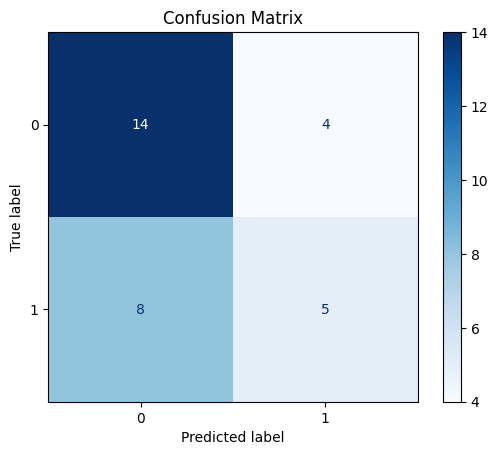

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1)  

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()